# 1.导入包

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import wandb
torch.__version__

'2.3.1'

# 2.设置超参数

In [2]:
BATCH_SIZE=512 #大概需要2G的显存
EPOCHS=20 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多

wandb.init(project="MNIST")
config = wandb.config
config.learning_rate = 0.001
config.epochs = 20
config.batch_size = 512

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zhanghaoyv (zhanghaoyv-henan-university). Use `wandb login --relogin` to force relogin


# 3.下载、转换并加载训练集

In [3]:
# 加载训练集
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=False, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

# 4.转换并加载测试集 

In [4]:
# 加载测试集
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

# 5.定义网络模型

In [5]:
# 定义网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 5) # 输入通道数1，输出通道数10，核的大小5
        self.conv2 = nn.Conv2d(10, 20, 3) # 输入通道数10，输出通道数20，核的大小3
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(20*10*10, 500) # 输入通道数是2000，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。

        out = self.conv1(x) # batch*1*28*28 -> batch*10*24*24（28x28的图像经过一次核为5x5的卷积，输出变为24x24）
        out = F.relu(out) # batch*10*24*24（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*24*24 -> batch*10*12*12（2*2的池化层会减半）

        out = self.conv2(out) # batch*10*12*12 -> batch*20*10*10（再卷积一次，核的大小是3）
        out = F.relu(out) # batch*20*10*10
        out = out.view(in_size, -1) # view：拉平（也称拉伸），将二维的图像平铺成一维的，一边进行后边的全连接层。这里是指将二十个通道的10*10的数据全部拉伸并平铺成一个2000维的向量。batch*20*10*10 -> batch*2000（out的第二维是-1，说明是自动推算，本例中第二维是20*10*10）

        out = self.fc1(out) # 全连接层：batch*2000 -> batch*500
        out = F.relu(out) # batch*500

        out = self.fc2(out) # batch*500 -> batch*10
        
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out

# 6.网络模型图解
<div style="white-space: nowrap; overflow-x: auto;">
    <img src="IMG_0085.jpeg" alt="Image 1" style="display: inline-block; width: 1050px; height: auto;">
    <img src="IMG_0086.jpeg" alt="Image 2" style="display: inline-block; width: 1050px; height: auto;">
</div>

# 7.定义优化器

In [6]:
# 定义优化器
model = ConvNet().to(DEVICE)
optimizer = optim.Adam(model.parameters())

# 8.定义训练方法

In [7]:
# 定义训练方法
def train(model, device, train_loader, optimizer, epoch):
    model.train() # 将模型设置为训练模式
    for batch_idx, (data, target) in enumerate(train_loader): # batch_idx是指某个batch的下标（从0开始），data 是从 train_loader 加载的一批训练样本，包含一个批次的数据
        data, target = data.to(device), target.to(device) # 部署到DEVICE上
        optimizer.zero_grad() # 梯度初始化为0
        output = model(data) # 将数据传递给模型，得到模型的预测输出
        loss = F.nll_loss(output, target) # 计算负对数似然损失
        loss.backward() # 反向传播，计算损失相对于模型参数的梯度
        optimizer.step() # 更新参数
        # 打印结果
        if(batch_idx+1)%30 == 0: # 每训练30个批次，打印一次当前的训练进度和损失值
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( # 分别保留0位小数和6位小数
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            wandb.log({"Train Loss": loss.item(), "epoch": epoch})

# 9.定义测试方法

In [8]:
# 定义测试方法
def test(model, device, test_loader):
    model.eval() # 将模型设置为评估模式，这种模式下会关闭 Dropout 并使用全局均值和方差，而不是批次的均值和方差。
    test_loss = 0
    correct = 0
    with torch.no_grad(): # 上下文管理器，用于禁用梯度计算。
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item() # target 是实际的类别标签，通常是一个形状为 (batch_size,) 的一维张量。view_as(pred) 将 target 的形状调整为与 pred 相同的形状 (batch_size, 1)，以便进行元素级的比较。eq 是 PyTorch 的元素级比较操作，它将 pred 和调整后的 target 逐元素进行比较，返回一个布尔张量，表示每个预测是否正确。

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    wandb.log({"Test Loss": test_loss, "Correct": correct, "Accuracy": 1. * correct / len(test_loader.dataset)})

# 注：<p style="color: pink; font-family: Arial">对上述“test()”的解释</p>
## <p style="color: orange; font-family: Arial">pred = output.max(1, keepdim=True)[1]</p>
1. output 是模型的预测输出，通常是一个二维张量，形状为 (batch_size, num_classes)，其中 batch_size 是批次大小（即有batch_size行0~9的概率的样本），num_classes 是类别数（即0的概率，1的概率，……，9的概率）。
2. max(1, keepdim=True) 操作在 output 张量的第一个维度（即batch_size）上寻找最大值。
   - 1 代表沿着第一个维度（即每行）中寻找最大值。
   - keepdim=True 表示保持输出的维度不变，即返回的结果仍然是一个二维张量。有几层中括号嵌套就有几个维度（如 [12,32] 是一维张量，而 [[12],[32]] 就是二维张量）。
   - 这个操作返回两个张量：
     - 最大值本身。（索引为0）
     - 最大值所在的索引。（即对应的类别，索引为1）
3. [1]
   - [1] 选择了 max 操作返回的第二个张量，即最大值索引的张量。
   - 这个张量 pred 的形状为 (batch_size, 1)，其中每个元素是该样本的预测类别索引。
## <p style="color: orange; font-family: Arial">correct += pred.eq(target.view_as(pred)).sum().item()</p>
1. target.view_as(pred)将 target 的形状调整为与 pred 相同的形状 (batch_size, 1)，以便进行元素级的比较。
2. eq 是 PyTorch 的元素级比较操作，它将 pred 和调整后的 target 逐元素进行比较，返回一个布尔张量，表示每个预测是否正确。
3. sum() 将布尔张量中的 True 值求和，得到预测正确的样本数。（得到的结果是只有一个数的标量张量，如在本例中可能为[9973],即预测正确的个数）（在 Python 中，True 相当于 1，False 相当于 0）
4. item() 将这个标量张量转换为普通的 Python 数值（整数型，如 [9973] -> 9973），以便累加到 correct 变量中。
5. 最终得到的 correct 是预测正确的总个数，而不是正确率。

# 10.开始训练

In [9]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

wandb.finish()
# 耗时1m40s

Train Epoch: 1 [14848/60000 (25%)]	Loss: 0.204200
Train Epoch: 1 [30208/60000 (50%)]	Loss: 0.179580
Train Epoch: 1 [45568/60000 (75%)]	Loss: 0.143057

Test set: Average loss: 0.1015, Accuracy: 9702/10000 (97%)

Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.089971
Train Epoch: 2 [30208/60000 (50%)]	Loss: 0.136035
Train Epoch: 2 [45568/60000 (75%)]	Loss: 0.063164

Test set: Average loss: 0.0525, Accuracy: 9824/10000 (98%)

Train Epoch: 3 [14848/60000 (25%)]	Loss: 0.072219
Train Epoch: 3 [30208/60000 (50%)]	Loss: 0.044464
Train Epoch: 3 [45568/60000 (75%)]	Loss: 0.086098

Test set: Average loss: 0.0415, Accuracy: 9863/10000 (99%)

Train Epoch: 4 [14848/60000 (25%)]	Loss: 0.044061
Train Epoch: 4 [30208/60000 (50%)]	Loss: 0.023826
Train Epoch: 4 [45568/60000 (75%)]	Loss: 0.036759

Test set: Average loss: 0.0327, Accuracy: 9882/10000 (99%)

Train Epoch: 5 [14848/60000 (25%)]	Loss: 0.028292
Train Epoch: 5 [30208/60000 (50%)]	Loss: 0.029318
Train Epoch: 5 [45568/60000 (75%)]	Loss: 0.046315

Test 

Accuracy,▁▅▆▇▇▇▇█▇▇█▇▇██▇▇███
Correct,▁▅▆▇▇▇▇█▇▇█▇▇██▇▇███
Test Loss,█▃▂▂▂▂▁▁▁▁▁▁▂▁▁▂▂▁▂▂
Train Loss,█▇▄▆▃▃▃▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Accuracy,0.9921
Correct,9921
Test Loss,0.03524
Train Loss,0.00203
epoch,20


# 11.查看卷积核

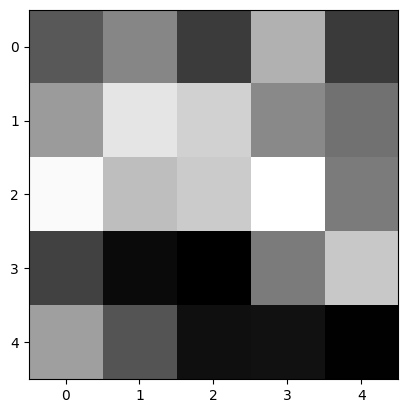

In [10]:
# 选择要查看的卷积层
conv_layer = model.conv1

# 获取卷积核的权重
kernels = conv_layer.weight.data.cpu()

# 如果需要，可以选择将卷积核可视化
# 这里我们展示第一个卷积核的第一个通道
kernel = kernels[0, 0, :, :]

plt.imshow(kernel, cmap='gray')
plt.show()

In [11]:
# 选择你要查看的卷积层，例如 model.conv1
conv_layer = model.conv1

# 获取卷积核的权重
kernels = conv_layer.weight.data.cpu().numpy()

# 查看卷积核的权重
print(kernels)

# 查看卷积核形状
print("卷积核的形状:", kernels.shape)

[[[[-0.06152695  0.03152335 -0.12073006  0.11741224 -0.1225052 ]
   [ 0.0737172   0.22378097  0.18335472  0.03701213 -0.01067862]
   [ 0.2662688   0.1438023   0.17070056  0.27754807  0.00772829]
   [-0.1076635  -0.21997023 -0.24198417  0.00843272  0.16523086]
   [ 0.08079229 -0.06974088 -0.21124376 -0.20694977 -0.2390114 ]]]


 [[[-0.2610012  -0.25657606  0.07575312 -0.12223057 -0.12266198]
   [-0.1311515  -0.1230423  -0.09677983 -0.10736368 -0.20514372]
   [ 0.08782323 -0.14257543  0.03613168 -0.0131584   0.00098582]
   [ 0.27116665  0.03021513 -0.07362312  0.07417988  0.16883011]
   [-0.07567716  0.26418895 -0.01190767 -0.15144494 -0.13621543]]]


 [[[ 0.04381867  0.02874119 -0.01326578 -0.11084831  0.21168226]
   [ 0.04873326  0.04401327  0.1642342   0.24968657  0.22604449]
   [-0.06182399  0.13544163 -0.08584588 -0.11422095 -0.0741    ]
   [-0.06215561 -0.11856619 -0.11896507 -0.13129945 -0.279226  ]
   [-0.1278965  -0.07958227 -0.07162569 -0.05924967  0.03401191]]]


 [[[ 0.040961